# Programming for Data Analysis Project
For this project I will be synthesizing a dataset, to do so I will be using various functions of the numpy.random package to create interpretations of real world phenomenon, a lot of the work done for this notebook will be in determining what this data looks like in reality so that the synthetic data is a fairly good reflection of it.

An example to illustrate this (as provided by the lecturer), is to consider students enrolled in a module, based on this example it seems sensible to consider each student has a grade at the end of a module and as we know from the common misconception that lecturers grade to a bell curve, is in fact due to the how phenomenon such as this tends to follow a normal distribution.
Following on from this we can assert that there are other factors that will help to determine their grade, such as their level of education going into this module (it stands to reason that someone with a PhD will in general outperform someone who has a bachelors degree), the amount of hours a student studies is also probably effecting their grade as is perhaps whether the student is full time or part time.  

## My Synthetic Data Idea - Adults Gender, Height, Weight and Age across the Irish Population prior to retirement

My idea here is to simulate a dataset for adults based on their Gender, Height, Weight and Age, for this I will be considering only those from the age of 18 to 64 and those who fall under the categories of health and over weight.

- Gender is an straight forward to start with as the population can be reasonably divided into half female and half male.

- Age is another direct factor to consider as it is wiill be independent of height and weight as neither of these will influence someones age.

- Height will be exclusively influenced by their gender, one of the assumptions made here is that a person stops getting taller after 18, which is not strictly true and likewise as people get past a certain age they also do lose some height.

- Finally weight will be influenced by all of the other factors, as someones gender, height and age will all factor into their weight.

### Exploring the variables in more detail and their relationships


In general with dependent and independent variables a variable can only be one or the other, however for this project as I am generating the variables in different steps I think it is fair to say that they all are dependent varaibles in a certain context, even though they are not directly influenced by the other variables within the dataset. 

What I mean by this is that Gender is something that is technically an independent variable for each of the other variables but when generating the different genders it is itself effected by the proportion of the overall population, which I will be using to determine the likelihood of any individual being female or male, therefore in that context Gender is a dependent variable and the independent variable is the female to male ratio of the population in Ireland.

#### Dependent variables and the Independent Variables that effect them
[Gender] <= [Proportion of Females to Males in Population]

[Age] <= [Proportion of Ages in Population], [Gender]

[Height] <= [Gender]

[Weight] <= [Gender], [Height]

***

On the face of it gender appears to be an easy 50 50 chance but for the sake of accuracy and to check the veracity of that claim I took a look at the Central Statistics Office (CSO) Census data for Men and Women, handily the CSO page also includes information for their ages as well.
[Link to CSO page on Men and Women](https://www.cso.ie/en/releasesandpublications/ep/p-cp3oy/cp3/assr/)

Based on the most recent census data (from 2016) the ratio of men to women is not quite equal, there is a minor difference between the ratio of men to women between the ages 15-64 of 980 men to 1000 women. More interestingly however the ratio of men to women broadens significantly when looking at the 65+ age group with 871 men to 1000 women.

## Determining Gender and Age using 2016 Census Data

As I was looking at the census data to determine how age is distributed from the ages of 18-64 and the census data is freely available to download I took a look at the dataset and have used it to determine the actual ratio of Female's to Male's  across the Irish population (as of 2016 at least), while also determining how age is distributed across the genders also.

As mentioned above, this dataset was taken from the CSO https://data.cso.ie/table/EY007 (you can find the downloaded dataset in csv format in the Data folder of this repository), it contains the Census data for 2016 which gives the numbers of individuals by gender across different ages.


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [67]:
rng = np.random.default_rng(1)

cso_df = pd.read_csv('Data\cso population 2011-2016.csv') #reading in csv file for dataset

#filter down to 2016, filter out all rows containing Both Sexes and include only rows showing population 
cso_df = cso_df[(cso_df['CensusYear']==2016) & (cso_df['Sex']!='Both sexes') & (cso_df['At Each Year of Age']=='Population') ] 

#Convert column containing age to be numeric and assign to new column
cso_df['Age'] = pd.to_numeric(cso_df['C02076V03371'],errors='coerce')

#drop unecessary columns as there is a lot of unecessary columns and confusingly named
cso_df = cso_df.drop(['STATISTIC', 'C02199V02655', 'Age Last Birthday', 'At Each Year of Age', 'UNIT', 'C02076V03371', 'C02786V03355', 'C02786V03355', 'TLIST(A1)', 'Statistic'], axis=1)

#filter down to the age group of interest 18 to 64
cso_df = cso_df[(cso_df['Age'] >=18) & (cso_df['Age'] <=64)].reset_index(drop=True)

#subset the dataframe into a male and female set, this is done to make getting proportions of the population simpler
cso_male_df = cso_df[cso_df['Sex']=='Male'].reset_index(drop=True)
cso_female_df = cso_df[cso_df['Sex']=='Female'].reset_index(drop=True)

# Now that dataframes have been cleaned and subsetted to the relevant data and groupings, 
# can get some statistics on the population

total_female_pop = cso_female_df['VALUE'].sum()
total_male_pop = cso_male_df['VALUE'].sum()
total_pop = total_male_pop + total_female_pop
female_percentage = total_female_pop/total_pop
male_percentage = total_male_pop/total_pop
print('Total women between ages 18-64 -', total_female_pop)
print('Total men between ages 18-64 - ', total_male_pop)
print('Total population between ages 18-64 -', total_pop)
print('Females as percentage of population -', female_percentage)
print('Males as percentage of population -', male_percentage)

Total women between ages 18-64 - 1484990
Total men between ages 18-64 -  1448806
Total population between ages 18-64 - 2933796
Females as percentage of population - 0.5061667546073415
Males as percentage of population - 0.49383324539265855


Based on the above I can now start to synthesize some fake data as I now have some representative figures for what percentage of the population Females and Males make up, so this is my first step.

In [68]:
#Creating a dataframe that starts with single column for gender 
df = pd.DataFrame(data=rng.choice(['Female','Male'], size=500, p=[female_percentage, male_percentage]), columns=['Gender'])
#Taking a peak at table so far
df

,Gender
0,Male
1,Male
2,Female
3,Male
4,Female
...,...
495,Male
496,Male
497,Female
498,Male


With the first variable in my dataset generated, I now want to look at adding age, but first I want to use the female and male dataframes from before to determine the probabilities for being a certain age.

To do so I will simply be creating some list's that track the percentage for 

In [86]:
#Get proportion of male population at different ages
#storing percentage, age, and count in different lists for simplicity and readability as they all get assigned in same loop
#should be no issues with ordering, see commented out dict line's below to see why it was removed
male_age_percentage_list = []
male_age_list = []
male_count_list = []
#male_age_dict = {}
for i in range(len(cso_male_df)):
    #get percentage of males at current age over total male population
    percentage = cso_male_df['VALUE'][i]/cso_male_df['VALUE'].sum()
    #append to list
    male_count_list.append(cso_male_df['VALUE'][i])
    male_age_percentage_list.append(percentage)
    male_age_list.append(int(cso_male_df['Age'][i]))
    #male_age_dict[int(cso_male_df['Age'][i])] = {'Percentage': percentage, 'Number':cso_male_df['VALUE'][i]}

In [87]:
#Get proportion of female population at different ages
female_age_percentage_list = []
female_age_list = []
female_count_list = []
#female_age_dict = {}
for i in range(len(cso_male_df)):
    #get percentage of females at current age over total female population
    percentage = cso_female_df['VALUE'][i]/cso_female_df['VALUE'].sum()
    #append to list
    female_count_list.append(cso_female_df['VALUE'][i])
    female_age_percentage_list.append(percentage)
    female_age_list.append(int(cso_female_df['Age'][i]))
    #female_age_dict[int(cso_female_df['Age'][i])] = {'Percentage': percentage, 'Number':cso_female_df['VALUE'][i]}

Text(0, 0.5, 'Number of population')

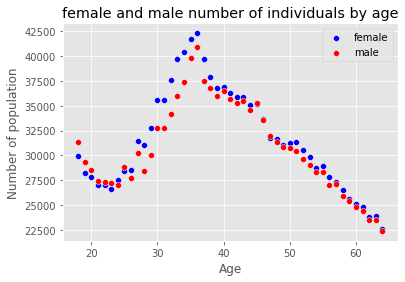

In [91]:
#visualising the distribution of age by gender
sns.scatterplot(x=cso_female_df['Age'],y=cso_female_df['VALUE'], color='b', label='female')
sns.scatterplot(x=cso_male_df['Age'],y=cso_male_df['VALUE'], color='red', label='male')
plt.title('female and male number of individuals by age')
plt.ylabel('Number of population')

The above scatter plot shows the number of females and males across different ages, and shows that age is indeed not normally distributed therefore I believe the only takeaway I can get from this, is the percentage of the overall population that each age makes up and using that to then determine a persons age by using weighted probabilities with numpy's choice function.

Further inspection of the scatter plot shows a few interesting bits, firstly that there seems to be a trend downwards from teenagers into their twenties, but then a linear population increase for any age up till around 38 years, whereafter it then has a linear descent. The descent after 38 makes sense intuitively to me, naturally as people age they have more chance of having died to some accident or to some disease. what makes less sense is that there is a population dip at around 20 years of age, I would presume that this is due to a tendency in first world countries to have declining birth rates as a country becomes more developed, however this would not explain the fact that there appears to be significantly more 18 and 19 year olds than 22 year olds.


## Adding Age as a variable to the dataset
Now that we've determined the probabilities for the various ages across males and females, in the next cell I will use this to assign ages based on the individuals gender. This will update the existing dataframe to now include a new column for our variable Age.

In [100]:
for index, row in df.iterrows():
    if(row['Gender'] == 'Female'):
        df.at[index,'Age'] = rng.choice(female_age_list, p=female_age_percentage_list)
    elif(row['Gender'] == 'Male'):
        df.at[index,'Age']  = rng.choice(male_age_list, p=male_age_percentage_list)
df

,Gender,Age,Height (cm)
0,Male,34.0,170.74
1,Male,46.0,171.94
2,Female,61.0,156.40
3,Male,22.0,175.40
4,Female,38.0,157.03
...,...,...,...
495,Male,24.0,175.93
496,Male,24.0,192.60
497,Female,58.0,158.26
498,Male,55.0,175.64


***
### Brief aside
In this next section I just wanted to see how the mean and standard deviations varied for men and women, this has no bearing on the dataset but I thought it was interesting.

In [10]:
female_age_sum = 0
female_age_sum_sq = 0
for i in range(len(female_age_list)):
    female_age_sum += female_age_list[i]*female_count_list[i]
mean_female_age = female_age_sum/total_female_pop

female_age_sum_sq = 0
for i in range(len(female_age_list)):
    female_age_sum_sq += female_count_list[i]*((female_age_list[i]-mean)**2)

stddev_female_age = np.sqrt(female_age_sum_sq/total_female_pop)

print(mean_female_age)
print(stddev_female_age)

40.318919992727224
12.717799985196626


In [11]:
male_age_sum = 0
male_age_sum_sq = 0
for i in range(len(male_age_list)):
    male_age_sum += male_age_list[i]*male_count_list[i]
mean_male_age = male_age_sum/total_male_pop

male_age_sum_sq = 0
for i in range(len(male_age_list)):
    male_age_sum_sq += male_count_list[i]*((male_age_list[i]-mean_male_age)**2)

stddev_male_age = np.sqrt(male_age_sum_sq/total_male_pop)

print(mean_male_age)
print(stddev_male_age)

40.343749266637495
12.814326493317076


Unsurprisingly the mean and standard deviation don't differ much, as we could see from the earlier scatter plot, they tend to track fairly closesly to one another.
***

### Determining and adding Female and Male heights as variables

This was somewhat tricky to find, which was surprising and I could not find any figures specific to Ireland so instead I am using the information available from [OurWorldInData](https://ourworldindata.org/human-height)

The above linked page gives several useful pieces of information for determining height
- Height is normally distributed
- Females have an average height of 164.7cm
    - With a Std. Deviation of 7.07cm
- Males have an average height of 178.4cm
    - With a Std. Deviation of 7.59cm

With the above information I can now start simulating data for adult Female and Male heights, however I would like to point out some of the generalisations made at this point. 

The average height and std. deviations listed above are not necessarily the case for Ireland, in fact they probably aren't totally accurate, however in the absence of any truly accurate figures for Ireland these will make a sufficient approximation.
Additionally the data presented from the link above uses a relatively young group of adults, which may further skew how the average height and std. deviation would be in reality as potentially for adults born in the 1970's their average height could be shorter than adults who were born in more recent years.

That aside, using the figures from above and applying them to my dataset using numpy's normal distribution function is done in the next code cell.

In [94]:
#Loop through each row of dataframe so far and check whether Female or Male
for index, row in df.iterrows():
    if(row['Gender'] == 'Female'):
        df.at[index,'Height (cm)'] = np.round(rng.normal(loc=164.7,scale=7.59, size=1),2)
    elif(row['Gender'] == 'Male'):
        df.at[index,'Height (cm)']  = np.round(rng.normal(loc=178.4,scale=7.07, size=1),2)

In [98]:
df.describe()

,Age,Height (cm)
count,500.000000,500.000000
mean,40.650000,171.590320
std,12.656852,10.063009
min,18.000000,146.270000
25%,30.000000,164.240000
50%,40.000000,172.170000
75%,51.000000,178.412500
max,64.000000,199.600000


In [27]:
df.head()

,Gender,Age,Height (cm),Weight Category,Weight (KG)
0,Male,37.0,173.02,Healthy Weight,61.384
1,Male,19.0,171.25,Over Weight,92.550
2,Female,26.0,171.39,Healthy Weight,57.782
3,Male,51.0,180.32,Healthy Weight,76.437
4,Female,22.0,173.00,Over Weight,101.877


In [26]:
df.tail()

,Gender,Age,Height (cm),Weight Category,Weight (KG)
495,Male,43.0,175.40,Over Weight,87.558
496,Male,61.0,171.25,Over Weight,90.841
497,Female,18.0,164.98,Healthy Weight,63.133
498,Male,57.0,173.80,Healthy Weight,68.264
499,Male,62.0,168.15,Healthy Weight,60.674


## Determining Weight using Gender
From the CSO website https://www.cso.ie/en/releasesandpublications/ep/p-wamii/womenandmeninireland2016/health/#d.en.142587 I was able see what the percentage of adult Females and Males are that are overweight, unfortunately I wasn't able to find a reliable figure for average weight or standard deviation, or how weight is generally distributed across the population.

Males overweight - 63.1%

Females overweight - 48.4%

Knowing the percentage of women and men that are overweight I am going to use this to information to determine for a given individual whether or not they are overweight.

Once it is determined whether or not they are overweight or a healthy weight (ignoring here the possibility of being severely underweight) I will estimate a value for the weight they are taking into account their height as the criteria for someone being overweight is proportional to their height (e.g. for two different individuals at the same weight one may be overweight and the other not if their weight differs significantly).

Whether someone is overweight or not is determined by their BMI and from the CSO page linked above, they cite a BMI between 25 and 30 as being pre-obese and anything greater than 30 as obese.
BMI is calculated using the formula:
\begin{align}
\ BMI & = \frac{m}{h^{2}} \\
\end{align}

Where m is mass (or Weight) in kg and h is height in cm.

In [16]:
for index, row in df.iterrows(): #loop through each row in dataframe
    if(row['Gender'] == 'Female'): #if row is gender then there is a 48.4% chance they are over weight
        df.at[index,'Weight Category'] = rng.choice(['Healthy Weight', 'Over Weight'], p=[.516,.484])
        if(df.at[index,'Weight Category'] =='Over Weight'): #depending on whether this person was over or healthy weight
            bmi_lower = 25
            bmi_upper = 35
        elif(df.at[index,'Weight Category'] =='Healthy Weight'):
            bmi_upper = 25
            bmi_lower = 18.5
    elif(row['Gender'] == 'Male'):
        df.at[index,'Weight Category'] = rng.choice(['Healthy Weight', 'Over Weight'], p=[.369,.631])
        if(df.at[index,'Weight Category'] =='Over Weight'):
            bmi_lower = 25
            bmi_upper = 35
        elif(df.at[index,'Weight Category'] =='Healthy Weight'):
            bmi_upper = 25
            bmi_lower = 18.5
    bmi = rng.uniform(bmi_lower,bmi_upper)
    height = df.at[index,'Height (cm)']/100
    weight = bmi*(height**2)
    df.at[index, 'Weight (KG)'] = np.round(weight, 3)

In [18]:
df

,Gender,Age,Height (cm),Weight Category,Weight (KG)
0,Male,37.0,173.02,Over Weight,88.469
1,Male,19.0,171.25,Healthy Weight,64.151
2,Female,26.0,171.39,Healthy Weight,54.440
3,Male,51.0,180.32,Over Weight,110.898
4,Female,22.0,173.00,Healthy Weight,68.189
...,...,...,...,...,...
495,Male,43.0,175.40,Healthy Weight,74.919
496,Male,61.0,171.25,Over Weight,94.889
497,Female,18.0,164.98,Over Weight,76.360
498,Male,57.0,173.80,Healthy Weight,68.511


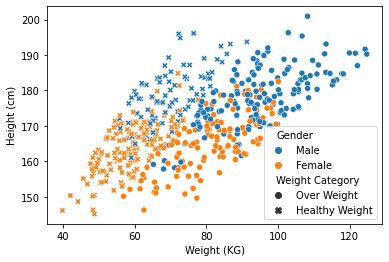

In [19]:
import seaborn as sns
sns.scatterplot( x='Weight (KG)', y='Height (cm)', data=df, hue='Gender', style='Weight Category');

### Instead of bmi being uniformly distributed what if it is infact normally distributed
I want to see what the difference will be if instead of bmi's for over weight and healthy weight being normally distributed, I thought that perhaps in reality they are centered around the median bmi and normally distributed, which is to say that a healthy weight person is more likely to be reliably far away from being under weight or over weight and similarly for an over weight individual.

To explain what I mean, I believe that a person who is either in the over weight or healthy weight categories to be more likely to the median value than edge cases, to capture this I am going to produce normal distributions with 2 standard deviations being the distance from median to upper or lower limits of bmi.

So a over weight bmi would have median of 30, with standard deviation of 2.5.
Healthy weight bmi has a median of 21.75 with a standard deviation of 1.625.

However by using 2 standard deviations to get from the median to the upper and lower limits does mean that in some rare cases (e.g. around 4 percent of the time) it will exceed the limits, to account for this I will add an if statement to check for this and to set the bmi in those cases to the nearest bmi limit.

In [20]:
for index, row in df.iterrows(): #loop through each row in dataframe
    if(row['Gender'] == 'Female'): #if row is gender then there is a 48.4% chance they are over weight
        df.at[index,'Weight Category'] = rng.choice(['Healthy Weight', 'Over Weight'], p=[.516,.484])
        if(df.at[index,'Weight Category'] =='Over Weight'): #depending on whether this person was over or healthy weight
            bmi = rng.normal(30,2.5)
            if (bmi<25): bmi = 25
            if (bmi>35): bmi = 35
        elif(df.at[index,'Weight Category'] =='Healthy Weight'):
            bmi = rng.normal(21.75,1.625)
            if (bmi<18.5): bmi = 18.5
            if (bmi>25): bmi = 25
    elif(row['Gender'] == 'Male'):
        df.at[index,'Weight Category'] = rng.choice(['Healthy Weight', 'Over Weight'], p=[.369,.631])
        if(df.at[index,'Weight Category'] =='Over Weight'):
            bmi = rng.normal(30,2.5)
            if (bmi<25): bmi = 25
            if (bmi>35): bmi = 35
        elif(df.at[index,'Weight Category'] =='Healthy Weight'):
            bmi = rng.normal(21.75,1.625)
            if (bmi<18.5): bmi = 18.5
            if (bmi>25): bmi = 25
    #bmi = rng.uniform(bmi_lower,bmi_upper)
    height = df.at[index,'Height (cm)']/100
    weight = bmi*(height**2)
    df.at[index, 'Weight (KG)'] = np.round(weight, 3)

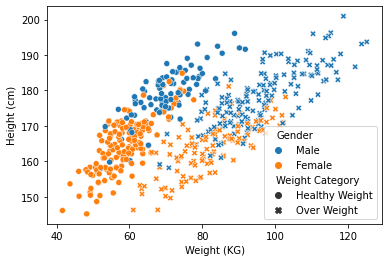

In [21]:
sns.scatterplot( x='Weight (KG)', y='Height (cm)', data=df, hue='Gender', style='Weight Category');